In [24]:
# %load_ext autotime
# !pip install autotime
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path
import warnings
import pandas as pd
import numpy as np
import time
import esm
import biotite.structure.io as bsio
from proteinttt.models.esmfold import ESMFoldTTT, DEFAULT_ESMFOLD_TTT_CFG
from proteinttt.utils.structure import calculate_tm_score, lddt_score
import torch
import argparse
import os


pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 100)
pd.set_option("max_colwidth", 1000)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
base_path = Path("/scratch/project/open-35-8/pimenol1/ProteinTTT/ProteinTTT/data/bfvd/")
SUMMARY_PATH = base_path / 'proteinttt_results.tsv'
MSA_PATH = Path("/scratch/project/open-35-8/antonb/bfvd/bfvd_msa")
SUBSET_PATH = base_path / 'proteinttt_msa_testset.tsv'

# Choosing data

In [27]:
df = pd.read_csv(SUBSET_PATH, sep="\t")
df.head(2)

,id,nmsa,pLDDT_AlphaFold,version,sequence,length,pLDDT_before,pLDDT_after,tm_score_before,lddt_before,tm_score_after,lddt_after,time,difference_plddt
0,A0A6J5N0Y1,335,91.472759,BASE,MEYKKQLLNELEKLTSLMDIPFARRTDIHWILQNVVMNNTDEKKIKKVISICQLLVKDETNG,62,63.227515,82.740176,0.49006,0.559835,0.44111,0.505525,36.530101,19.512661
1,A5A3S1,7,90.812526,BASE+LOGAN+12CY,MKEHVIIAPNYRLGEYAARFILEVSPRSCIFVSLDSRGDCERLNGLSDDLLNFHYFYAPRMDWTQEMRKNYEIMNHILAPRNIELTIHRLP,91,56.789921,77.589684,0.69936,0.683160,0.89881,0.854535,37.654090,20.799763


In [30]:
df.lddt_after.describe()

count    100.000000
mean       0.674109
std        0.204814
min        0.271548
25%        0.500863
50%        0.686340
75%        0.842984
max        1.000000
Name: lddt_after, dtype: float64

In [23]:
# df_r = df.query('pLDDT_AlphaFold > 90 and pLDDT_before < 70').sample(100)
# df2 = df1.query('pLDDT_before <50')
# df3 = df1.query('pLDDT_before >50')

# df_r = pd.concat([df2.sample(40), df3.sample(60)])
# df_r.to_csv(SUBSET_PATH, sep="\t", index=False)
# df_r

<Axes: >

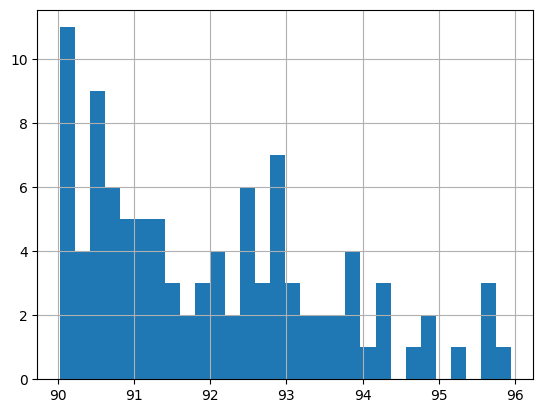

In [28]:
df_r.pLDDT_AlphaFold.hist(bins=30)

<Axes: >

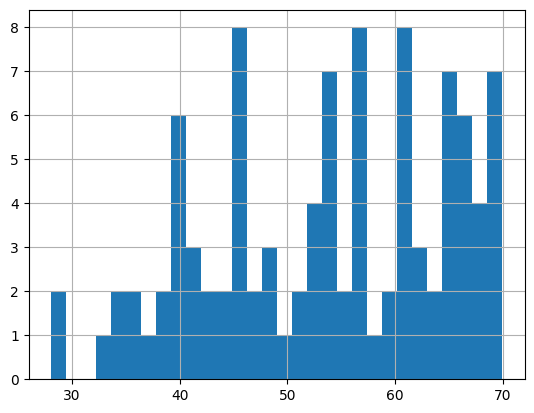

In [25]:
df_r.pLDDT_before.hist(bins=30)

<Axes: >

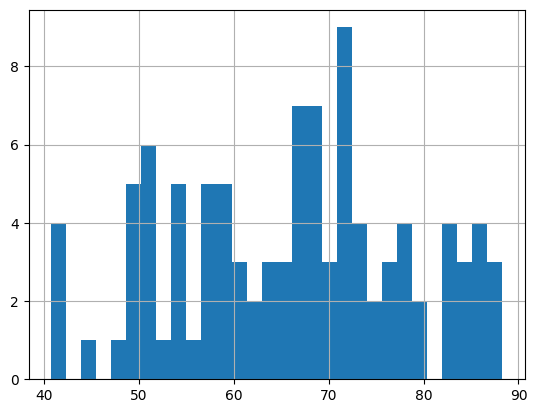

In [26]:
df_r.pLDDT_after.hist(bins=30)

<Axes: >

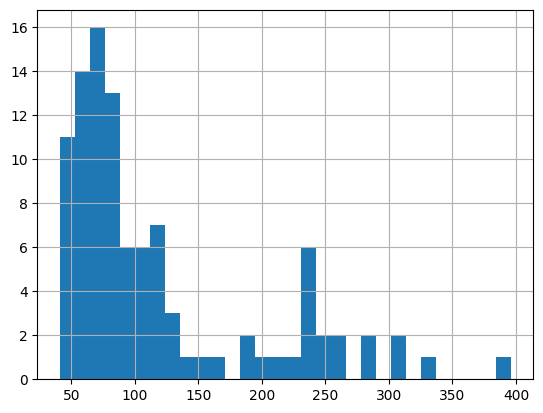

In [27]:
df_r.length.hist(bins=30)

In [9]:
# pd.read_csv(base_path / 'results_3314713.tsv', sep="\t")
# 4e-05 4
# 4e-04 4

# Merge results

In [19]:
results = pd.read_csv('/scratch/project/open-35-8/pimenol1/ProteinTTT/ProteinTTT/data/bfvd/results_msa_grad_clip/results_3318978.tsv', sep="\t")[['id', 'nmsa', 'pLDDT_AlphaFold', 'version', 'sequence', 'length',
       'pLDDT_before', 'pLDDT_after', 'tm_score_before', 'lddt_before',
       'tm_score_after', 'lddt_after', 'time', 'difference_plddt']]
for file in os.listdir(base_path/'results_msa_grad_clip'):
    if file.startswith("results_"):
        temp_df = pd.read_csv(base_path / 'results_msa_grad_clip' / file, sep="\t")
        results = pd.merge(results, temp_df.drop(columns=['nmsa', 'pLDDT_AlphaFold', 'version', 'sequence', 'length',
       'pLDDT_before', 'pLDDT_after', 'tm_score_before', 'lddt_before',
       'tm_score_after', 'lddt_after', 'time', 'difference_plddt']), on='id', how='left')
results.head(10)

,id,nmsa,pLDDT_AlphaFold,version,sequence,length,pLDDT_before,pLDDT_after,tm_score_before,lddt_before,tm_score_after,lddt_after,time,difference_plddt,pLDDT_0.004_32,lddt_0.004_32,tm_score_0.004_32,pLDDT_4e-05_16,lddt_4e-05_16,tm_score_4e-05_16,pLDDT_0.004_8,lddt_0.004_8,tm_score_0.004_8,pLDDT_0.0004_16,lddt_0.0004_16,tm_score_0.0004_16,pLDDT_4e-05_4,lddt_4e-05_4,tm_score_4e-05_4,pLDDT_0.004_4,lddt_0.004_4,tm_score_0.004_4,pLDDT_0.0004_4,lddt_0.0004_4,tm_score_0.0004_4,pLDDT_0.004_16,lddt_0.004_16,tm_score_0.004_16,pLDDT_4e-05_32,lddt_4e-05_32,tm_score_4e-05_32,pLDDT_0.0004_8,lddt_0.0004_8,tm_score_0.0004_8,pLDDT_0.0004_32,lddt_0.0004_32,tm_score_0.0004_32,pLDDT_4e-05_8,lddt_4e-05_8,tm_score_4e-05_8
0,A0A6J5N0Y1,335,91.472759,BASE,MEYKKQLLNELEKLTSLMDIPFARRTDIHWILQNVVMNNTDEKKIKKVISICQLLVKDETNG,62,63.227515,82.740176,0.49006,0.559835,0.44111,0.505525,36.530101,19.512661,63.268297,0.555290,0.48850,63.262094,0.559587,0.49037,63.522740,0.554787,0.48717,63.244344,0.559587,0.49033,63.265656,0.559803,0.49036,63.362935,0.556035,0.48932,63.273014,0.558993,0.49028,63.301018,0.557271,0.48946,63.278141,0.559992,0.49052,63.252798,0.559794,0.49037,63.229883,0.559830,0.49006,63.299217,0.559794,0.49043
1,A5A3S1,7,90.812526,BASE+LOGAN+12CY,MKEHVIIAPNYRLGEYAARFILEVSPRSCIFVSLDSRGDCERLNGLSDDLLNFHYFYAPRMDWTQEMRKNYEIMNHILAPRNIELTIHRLP,91,56.789921,77.589684,0.69936,0.683160,0.89881,0.854535,37.654090,20.799763,83.357382,0.906348,0.93450,58.107842,0.682932,0.69435,70.584632,0.817939,0.82817,70.163750,0.785958,0.79158,57.332500,0.685034,0.70005,67.875145,0.775571,0.76901,63.237355,0.736409,0.73779,72.379224,0.768842,0.77472,60.279263,0.738005,0.73979,68.981461,0.787851,0.78707,62.855947,0.737920,0.73748,57.378697,0.684814,0.70020
2,A0A646QXE5,55,91.541814,BASE+LOGAN,MQVKITANANALVLGTDTLIAANNELYTKLETCHVEVNPSTGKIVKVHLDRPGNNHYDVLIGTTAGTVHRVQVGEITTSGGFCTYLDSL,89,39.286597,49.705892,0.28820,0.371947,0.43017,0.431789,35.734640,10.419295,39.556822,0.376973,0.34526,39.938456,0.375478,0.29385,40.205817,0.396525,0.36797,39.277856,0.372529,0.29119,39.494468,0.372901,0.29222,39.994168,0.373532,0.30972,39.106282,0.367581,0.28526,39.389955,0.396498,0.37113,39.674918,0.372416,0.29214,39.368216,0.368681,0.28625,39.397796,0.376144,0.30032,39.559370,0.375073,0.29065
3,A0A7T0Q4S0,203,92.460221,BASE+LOGAN+12CY,MYFPVTIKIIQIEDKLDITIEKGIEAEFVITRAICSCGFMFKIPIIERSDTCFTYKSFYQTNYSGHHINNFKLSFVNGSAIVLSALEEFEGSQLELQHIFEFSLWDFTNFNSITHHYGYTCDYSQF,126,28.079356,53.452375,0.30882,0.303376,0.50438,0.395662,43.042365,25.373019,28.712808,0.297052,0.31190,28.351125,0.304831,0.30675,28.982817,0.300826,0.31649,29.022933,0.301889,0.30911,28.430529,0.306316,0.30802,29.050173,0.301727,0.32353,29.074990,0.301059,0.31742,29.125163,0.299736,0.30915,28.403558,0.303687,0.31479,28.734183,0.305200,0.30583,29.189721,0.302869,0.30910,28.287240,0.305435,0.30556
4,A0A8S5SDJ0,147,92.442504,BASE,MKMFAEVRNDYCFEELKNGIKAGITIDVWKTDDENEEGEVAATVILSEHNDIIVVWHLNYARRDQECLLAIEEAKNILKEEI,82,67.063268,68.156072,0.80463,0.616864,0.81686,0.642290,35.410922,1.092804,67.697076,0.634525,0.81421,67.780015,0.650346,0.81736,67.838321,0.634588,0.81530,67.778201,0.633449,0.81411,67.063268,0.616864,0.80463,68.143898,0.639362,0.81994,67.063268,0.616864,0.80463,68.486252,0.634678,0.81460,67.872774,0.650232,0.81772,67.063268,0.616864,0.80463,67.710810,0.636351,0.82248,67.063268,0.616864,0.80463
5,A0A516M7D4,316,90.798038,BASE,MKLIMENWKRFLKESEMYDYEPEKFGPLSVYHADAGEYGQIVLYHMMPKIGDNLIYLVGTLTYDLTMEPCVPETFQVSAVYVEKLARGNKYAKLMYDLAFYIVGEKGAGLTSDHMVGTTKIAKDKAWNYINSAESEYNKRKTDQGNAKFDYNNSTPDDPNDDCDSGLEGKEMATDYSYSMVNTSEPAAKYKMLIRNHLLNIRYLRGGKNMMWLEKELTNRADEGFNRAHLEQTSIED,237,46.566306,51.510262,0.50840,0.490958,0.63228,0.507660,97.545487,4.943956,48.284872,0.490313,0.52555,46.595463,0.491272,0.50760,46.577834,0.490469,0.50857,46.958776,0.495329,0.51242,46.585625,0.490532,0.50727,46.858776,0.490603,0.50624,46.788864,0.488458,0.49940,46.577834,0.490469,0.50857,46.587514,0.491073,0.50861,46.614045,0.490832,0.50721,46.890246,0.489444,0.50108,46.5814

In [28]:
results.columns

Index(['id', 'nmsa', 'pLDDT_AlphaFold', 'version', 'sequence', 'length',
       'pLDDT_before', 'pLDDT_after', 'tm_score_before', 'lddt_before',
       'tm_score_after', 'lddt_after', 'time', 'difference_plddt',
       'pLDDT_0.004_32', 'lddt_0.004_32', 'tm_score_0.004_32',
       'pLDDT_4e-05_16', 'lddt_4e-05_16', 'tm_score_4e-05_16', 'pLDDT_0.004_8',
       'lddt_0.004_8', 'tm_score_0.004_8', 'pLDDT_0.0004_16', 'lddt_0.0004_16',
       'tm_score_0.0004_16', 'pLDDT_4e-05_4', 'lddt_4e-05_4',
       'tm_score_4e-05_4', 'pLDDT_0.004_4', 'lddt_0.004_4', 'tm_score_0.004_4',
       'pLDDT_0.0004_4', 'lddt_0.0004_4', 'tm_score_0.0004_4',
       'pLDDT_0.004_16', 'lddt_0.004_16', 'tm_score_0.004_16',
       'pLDDT_4e-05_32', 'lddt_4e-05_32', 'tm_score_4e-05_32',
       'pLDDT_0.0004_8', 'lddt_0.0004_8', 'tm_score_0.0004_8',
       'pLDDT_0.0004_32', 'lddt_0.0004_32', 'tm_score_0.0004_32',
       'pLDDT_4e-05_8', 'lddt_4e-05_8', 'tm_score_4e-05_8'],
      dtype='object')

In [4]:
len(os.listdir(base_path / 'logs_msa_4e-05_32'))

FileNotFoundError: [Errno 2] No such file or directory: '/scratch/project/open-35-8/pimenol1/ProteinTTT/ProteinTTT/data/bfvd/logs_msa_4e-05_32'

# Plots

LR: 0.004
AGS: 4
LR: 0.004
AGS: 8
LR: 0.004
AGS: 16
100


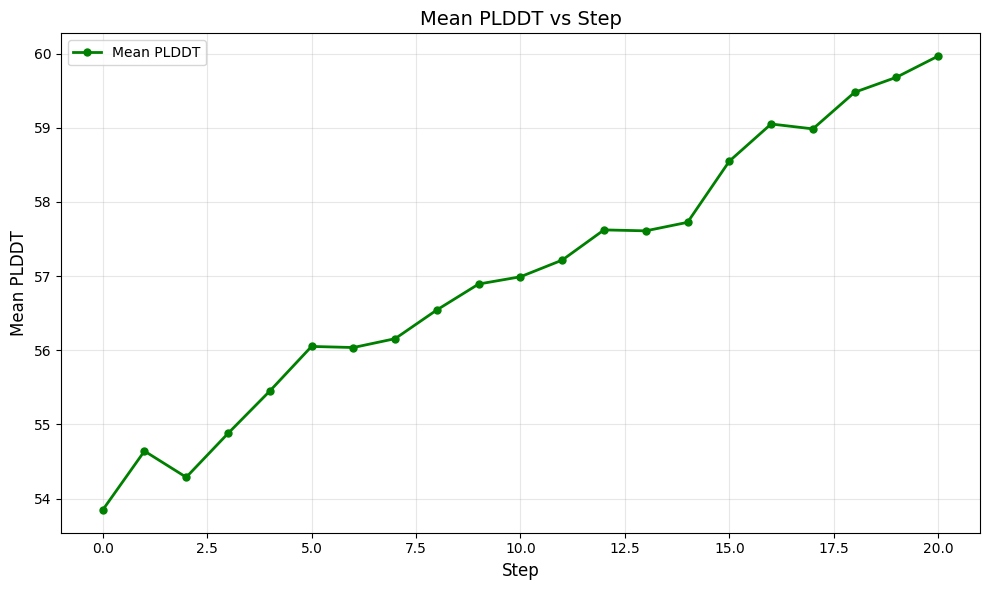

LR: 0.004
AGS: 32
LR: 0.0004
AGS: 4
LR: 0.0004
AGS: 8
LR: 0.0004
AGS: 16
LR: 0.0004
AGS: 32
LR: 4e-05
AGS: 4
LR: 4e-05
AGS: 8
LR: 4e-05
AGS: 16
LR: 4e-05
AGS: 32


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import glob

def plot_mean_scores_vs_step(logs_dir, hyperparams=None, output_path=None, metric='plddt'):
    """
    Create plots showing mean of a chosen metric (plddt, lddt, or tmscore) across all proteins at each step, 
    organized by hyperparameter combinations.
    
    Args:
        logs_dir: Path to directory containing log files (e.g., 'logs_msa_0.0004_4')
        hyperparams: Optional dict with parameter mappings if you want to organize by params
                    e.g., {'lr': [4e-5, 4e-4, 4e-3], 'ags': [4, 8, 16, 32]}
        output_path: Optional path to save the figure
        metric: The metric to plot. Can be 'plddt', 'lddt', or 'tmscore'. Defaults to 'plddt'.
    """
    
    # Read all log files
    log_files = glob.glob(str(Path(logs_dir) / '*_log.tsv'))
    print(len(log_files))
    if not log_files:
        print(f"No log files found in {logs_dir}")
        return
    
    # Collect data from all log files
    all_data = []
    for log_file in log_files:
        try:
            # Read with quoting to handle multiline pdb column
            df = pd.read_csv(log_file, sep='\t', quoting=1)  # QUOTE_MINIMAL
            all_data.append(df)
        except Exception as e:
            print(f"Error reading {log_file}: {e}")
            continue
    
    if not all_data:
        print("No valid log files could be read")
        return
    
    # Combine all dataframes
    combined_df = pd.concat(all_data, ignore_index=True)
    
    # Validate metric
    if metric not in ['plddt', 'lddt', 'tm_score']:
        print(f"Error: Invalid metric '{metric}'. Choose from 'plddt', 'lddt', or 'tm_score'.")
        return None # Return None in case of error

    # Calculate mean of the chosen metric for each step across all proteins
    mean_metric = combined_df.groupby('step')[metric].mean()
    
    # If hyperparams are provided, create subplots for each combination
    if hyperparams:
        # Extract parameter values from hyperparams dict
        param1_name = list(hyperparams.keys())[0]
        param1_values = hyperparams[param1_name]
        param2_name = list(hyperparams.keys())[1]
        param2_values = hyperparams[param2_name]
        
        nrows, ncols = len(param2_values), len(param1_values)
        fig, axes = plt.subplots(nrows, ncols, figsize=(20, 15)) 
        
        # Flatten axes for easier iteration
        axes = axes.flatten() if nrows > 1 or ncols > 1 else [axes]
        
        for i, (lr, ags) in enumerate([(lr, ags) for ags in param2_values for lr in param1_values]):
            # Filter data for this hyperparameter combination
            subset_df = combined_df[combined_df['step'].notna()]
            mean_metric_subset = subset_df.groupby('step')[metric].mean()
            
            ax = axes[i]
            ax.plot(mean_metric_subset.index, mean_metric_subset.values, 
                   'o-', color='green', linewidth=2, markersize=5, label=f'Mean {metric.upper()}')
            
            ax.set_xlabel('Step', fontsize=10)
            ax.set_ylabel(f'Mean {metric.upper()}', fontsize=10) 
            ax.tick_params(axis='y')
            ax.set_title(f'{param1_name}: {lr}, {param2_name}: {ags}', fontsize=9)
            ax.grid(True, alpha=0.3)
            ax.legend(loc='upper left')
        
        plt.tight_layout()
    else:
        # Simple single plot
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.plot(mean_metric.index, mean_metric.values, 
               'o-', color='green', linewidth=2, markersize=5, label=f'Mean {metric.upper()}')
        ax.set_xlabel('Step', fontsize=12)
        ax.set_ylabel(f'Mean {metric.upper()}', fontsize=12) 
        ax.tick_params(axis='y')
        ax.set_title(f'Mean {metric.upper()} vs Step', fontsize=14) 
        ax.grid(True, alpha=0.3)
        ax.legend(loc='best')
        plt.tight_layout()
    
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
    
    plt.show()
    
    return mean_metric

from pathlib import Path

base_path = Path("/scratch/project/open-35-8/pimenol1/ProteinTTT/ProteinTTT/data/bfvd/logs_msa")

# Simple plot for a specific log directory
# mean_metric_single = plot_mean_scores_vs_step(base_path / 'logs_msa_0.004_4', metric='plddt')

# Or with hyperparameter organization
hyperparams = {
    'lr': [0.004, 0.0004, 4e-05],
    'ags': [4, 8, 16, 32]
}
for lr in hyperparams['lr']:
    for ags in hyperparams['ags']:
        print("LR:", lr)
        print("AGS:", ags)
        if lr == 0.004 and ags == 16:
            plot_mean_scores_vs_step(base_path / f'logs_msa_{lr}_{ags}', metric='plddt')


In [3]:
from Bio import SeqIO


def check_a3m_lengths(filepath):
    lengths = {}
    try:
        for record in SeqIO.parse(filepath, format="fasta"):
            # DELETE all lowercase letters from the sequence
            for char in record.seq:
                if char.islower():
                    record.seq = record.seq.replace(char, "")
            lengths[record.id] = len(record.seq)

        first_record_id = list(lengths.keys())[0]
        reference_length = lengths[first_record_id]

        print(f"Reference sequence: '{first_record_id}' (Length: {reference_length})")

        is_consistent = True
        for seq_id, length in lengths.items():
            if length != reference_length:
                print(f"MISMATCH: '{seq_id}' has length {length}")
                is_consistent = False

        if is_consistent:
            print(f"All {len(lengths)} sequences have the same length: {reference_length}")

    except Exception as e:
        print(f"An error occurred: {e}")

file_to_check = "/scratch/project/open-35-8/antonb/bfvd/bfvd_msa/A0A1M7XUY2.a3m"
check_a3m_lengths(file_to_check)

Reference sequence: 'UniRef100_A0A1M7XUY2' (Length: 437)
All 2527 sequences have the same length: 437


In [30]:
results.pLDDT_after.mean(), results.pLDDT_before.mean(), results['pLDDT_0.0004_4'].mean()

(66.00136074541415, 53.70356051607253, 55.61832557561105)

In [23]:
t = pd.read_csv('/scratch/project/open-35-8/pimenol1/ProteinTTT/ProteinTTT/data/bfvd/results_msa/results_3321816.tsv', sep="\t")
t['pLDDT_4e-05_8'].describe()
# t

count    100.000000
mean      61.406598
std       14.733958
min       29.159106
25%       47.411812
50%       63.373106
75%       71.816669
max       87.446723
Name: pLDDT_4e-05_8, dtype: float64

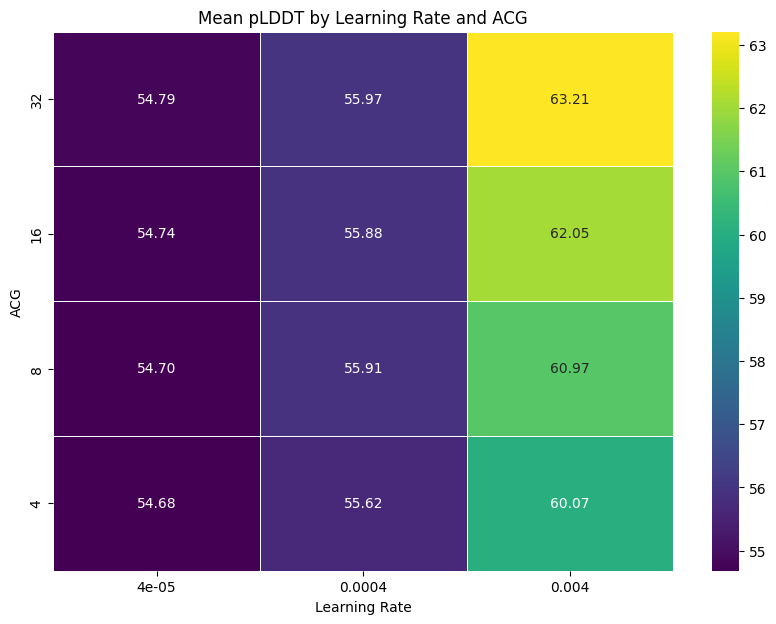

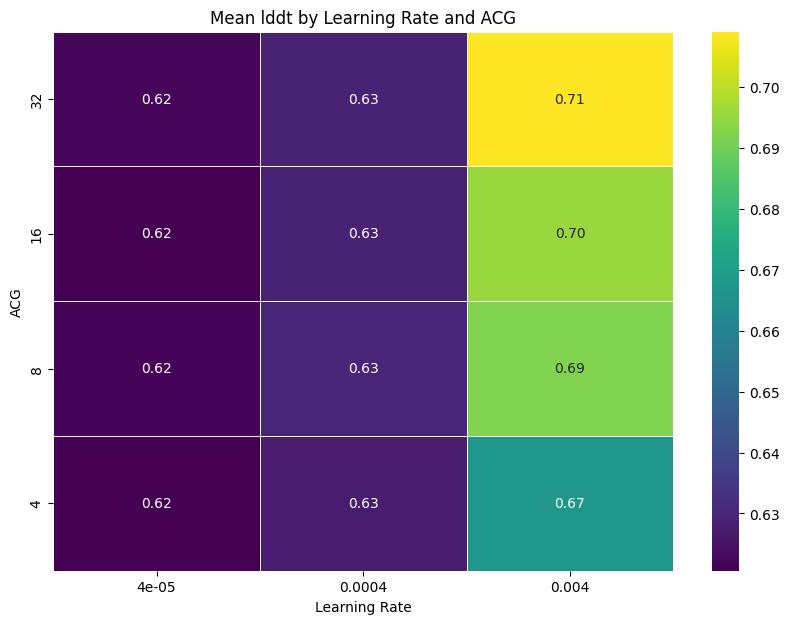

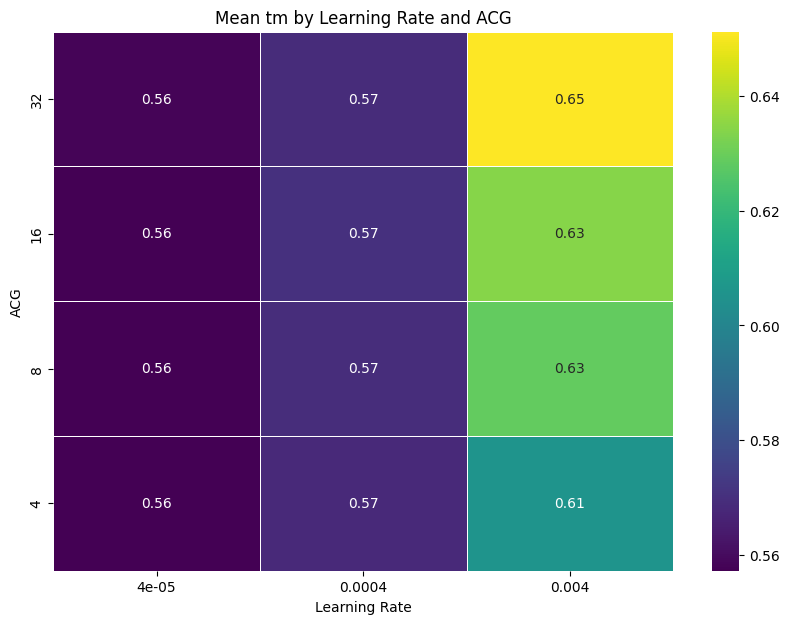

In [20]:
import re
import matplotlib.pyplot as plt
import seaborn as sns

# Extract learning rate and acg from column names
# The column names are in the format "metric_learningrate_acg"
def extract_params(col_name):
    match = re.search(r'_(\d(?:\.\d+)?e?-?\d*)_(\d+)', col_name)
    if match:
        lr = float(match.group(1))
        acg = int(match.group(2))
        return lr, acg
    return None, None

# List of columns to process
columns_to_process = [
    'pLDDT_0.004_32', 'lddt_0.004_32', 'tm_score_0.004_32',
       'pLDDT_4e-05_16', 'lddt_4e-05_16', 'tm_score_4e-05_16', 'pLDDT_0.004_8',
       'lddt_0.004_8', 'tm_score_0.004_8', 'pLDDT_0.0004_16', 'lddt_0.0004_16',
       'tm_score_0.0004_16', 'pLDDT_4e-05_4', 'lddt_4e-05_4',
       'tm_score_4e-05_4', 'pLDDT_0.004_4', 'lddt_0.004_4', 'tm_score_0.004_4',
       'pLDDT_0.0004_4', 'lddt_0.0004_4', 'tm_score_0.0004_4',
       'pLDDT_0.004_16', 'lddt_0.004_16', 'tm_score_0.004_16',
       'pLDDT_4e-05_32', 'lddt_4e-05_32', 'tm_score_4e-05_32',
       'pLDDT_0.0004_8', 'lddt_0.0004_8', 'tm_score_0.0004_8',
       'pLDDT_0.0004_32', 'lddt_0.0004_32', 'tm_score_0.0004_32',
       'pLDDT_4e-05_8', 'lddt_4e-05_8', 'tm_score_4e-05_8'
]

# Create a list to store the extracted data
data_for_heatmap = []

for col in columns_to_process:
    lr, acg = extract_params(col)
    if lr is not None and acg is not None:
        # Assuming 'results' is your dataframe loaded in cell 11
        mean_value = results[col].mean()
        metric_name = col.split('_')[0] # e.g., pLDDT, lddt, tm_score
        data_for_heatmap.append({'Learning Rate': lr, 'ACG': acg, 'Metric': metric_name, 'Mean Value': mean_value})

# Convert to DataFrame for easier pivoting
heatmap_df = pd.DataFrame(data_for_heatmap)

# Pivot the table to get 'Learning Rate' on x-axis, 'ACG' on y-axis, and 'Mean Value' as values
# We will create a separate heatmap for each metric (pLDDT, lddt, tm_score)

metrics = heatmap_df['Metric'].unique()

for metric in metrics:
    metric_df = heatmap_df[heatmap_df['Metric'] == metric]
    pivot_table = metric_df.pivot_table(index='ACG', columns='Learning Rate', values='Mean Value')

    # Sort the index (ACG) and columns (Learning Rate) for better visualization
    pivot_table = pivot_table.sort_index(ascending=False)
    pivot_table = pivot_table.sort_index(axis=1)

    plt.figure(figsize=(10, 7))
    sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="viridis", linewidths=.5)
    plt.title(f'Mean {metric} by Learning Rate and ACG')
    plt.xlabel('Learning Rate')
    plt.ylabel('ACG')
    plt.show()
